In [ ]:
from src import QuantumSystemConfig, QuantumSystem

import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_qubits = 6
init_ones = [2, 3]
init_state = ''.join(['1' if i in init_ones else '0' for i in range(num_qubits)])[::-1]
J = 0.2
h = 1.2
alpha = np.pi / 8.0
time = 30.0
qutip_times = np.linspace(0, time, 301)
times = np.linspace(0, time, 61)

In [3]:
def ising_hamiltonian_tuples(nqubits, J, h, alpha):
    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, nqubits - 1)]
    Z_tuples = [("Z", [i], -h * np.sin(alpha)) for i in range(0, nqubits)]
    X_tuples = [("X", [i], -h * np.cos(alpha)) for i in range(0, nqubits)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    return [*ZZ_tuples, *Z_tuples, *X_tuples]

In [4]:
hamiltonian_tuples = ising_hamiltonian_tuples(num_qubits, J, h, alpha)

magnetization_tuples = [("Z", [i], 1.0/num_qubits) for i in range(0, num_qubits)]
correlation_tuples = [("ZZ", [i, i + 1], 1.0/ (num_qubits - 1)) for i in range(0, num_qubits - 1)]
e_ops_tuples = [hamiltonian_tuples, magnetization_tuples, correlation_tuples]

In [5]:
qsc = QuantumSystemConfig(
    num_qubits=num_qubits,
    init_state=init_state,
    hamiltonian_tuples=hamiltonian_tuples,
    e_ops_tuples=e_ops_tuples,
    optimization_level=3, 
)

qs = QuantumSystem(config=qsc)

In [6]:
qutip_results = qs.perform_qutip_time_evolution(qutip_times)

In [7]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

fake_backend = FakeSherbrooke()
orders = [1, 2]
ideal_results = []
noisy_results = []

for order in orders:
    qs.config.set_synthesis_parameters(order=order)
    for backend, results_list in zip(
        [None, fake_backend], [ideal_results, noisy_results]
    ):
        qs.config.set_backend(backend)
        results = qs.perform_qiskit_time_evolution(times)
        results_list.append(results)

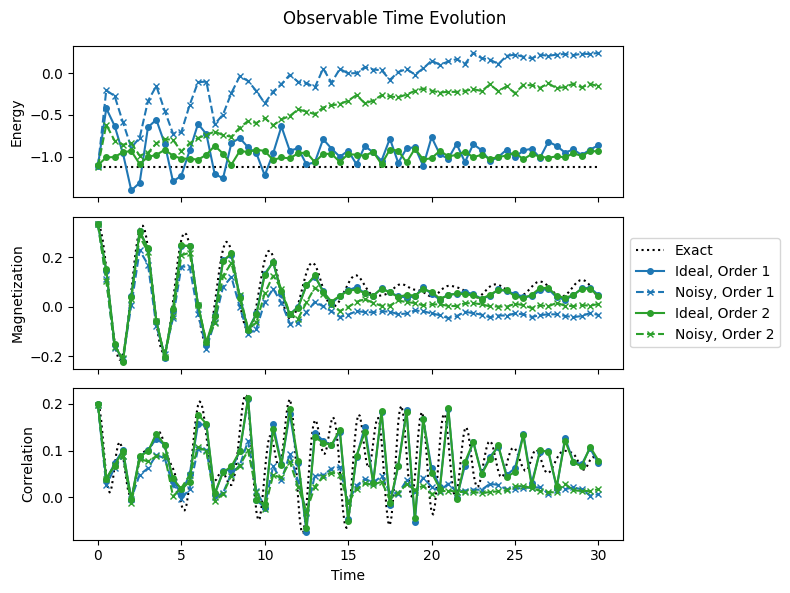

In [11]:
fig, axes = plt.subplots(len(e_ops_tuples), 1, figsize=(8, 2 * len(e_ops_tuples)))
labels = ["Energy", "Magnetization", "Correlation"]

for order, ideal_result, noisy_result in zip(
    orders, ideal_results, noisy_results
):
    for (
        ax, 
        label,
        (qutip_ev, ideal_ev, noisy_ev),
    ) in zip(
        axes.flat,
        labels,
        zip(
            qutip_results,
            ideal_result,
            noisy_result,
        ),
    ):
        if order == orders[0]:
            ax.plot(qutip_times, qutip_ev, "k:", label="Exact")
        ax.plot(times, ideal_ev, label=f"Ideal, Order {order}", marker="o", markersize=4)
        ax.plot(times, noisy_ev, label=f"Noisy, Order {order}", marker="x", markersize=4, linestyle="--")
        
        lines = ax.get_lines()
        lines[-1].set_color(lines[-2].get_color())
        
        ax.set_xlabel("Time")
        ax.set_ylabel(label)
        ax.label_outer()
        
        if ax == axes.flat[len(e_ops_tuples)//2]:
            ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
            
fig.suptitle("Observable Time Evolution")
plt.tight_layout()
plt.savefig("observable_time_evolution.png", dpi=300)
plt.show()